In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Pong/')
!ls

ball.png  environment.py  model.py  paddle.png	__pycache__  replayBuffer.py


In [3]:
!pip uninstall numpy

Found existing installation: numpy 1.25.2
Uninstalling numpy-1.25.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.25.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-1.25.2


In [4]:
!pip install "numpy>=1.23.5,<2.0.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 27.9 MB/s eta 0:00:00


In [5]:
import gym
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
from IPython import display
import matplotlib.pyplot as plt
import os
import time
from model import DQN
from environment import PongEnvironment
from replayBuffer import ReplayBuffer

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [7]:

# Helper functions
def update_dqn(model:torch.nn.Module, target_model:torch.nn.Module, optimizer, batch, replay_buffer, gamma, losses):
    states, actions, rewards, next_states, dones = batch

    states = states.to(device)
    actions = actions.long().to(device)
    rewards = rewards.to(device)
    next_states = next_states.to(device)
    dones = dones.to(device)


    states = states.view(states.size(0), -1)
    next_states = next_states.view(next_states.size(0), -1)

    q_values = model(states).gather(1, actions.view(-1, 1)).squeeze(1)
    next_q_values = target_model(next_states).max(dim=1)[0].detach()

    target_q_values = rewards + gamma * next_q_values * (1 - dones)


    criterion = torch.nn.SmoothL1Loss()
    loss = criterion(q_values, target_q_values.detach())
    # loss = F.mse_loss(q_values, target_q_values.detach())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss, q_values.mean().item()


def epsilon_greedy_policy(state, epsilon, model, action_size):
    if np.random.rand() < epsilon:
        return np.random.choice(action_size)
    else:
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32).view(1, -1).to(device)
            q_values = model(state)
            return q_values.argmax().item()


In [8]:
# Defining hyperparameters
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
target_update_freq = 1000
learning_rate = 0.001
num_episodes = 10
losses = []
avg_q_values = []
episode_rewards_list = []
state_size = 6
action_size = 2
batch_size = 64

# Initializing environments
env = PongEnvironment()
replay_buffer = ReplayBuffer(observation_size=state_size)

model = DQN(state_size).to(device)
target_model = DQN(state_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
if os.path.isfile("trained_model.pth"):
    checkpoint = torch.load("trained_model.pth", map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    losses = checkpoint['losses']
    avg_q_values = checkpoint['avg_q_values']
    total_num_episodes = checkpoint['total_num_episodes']
    episode_rewards_list = checkpoint['episode_rewards']
    if os.path.isfile('buffer.pkl'):
        replay_buffer.load_buffer()
    model.train()
else:
    print("TRAINING FOR FIRST TIME!")
    total_num_episodes = 0
    model.train()

TRAINING FOR FIRST TIME!


In [10]:
target_model.load_state_dict(model.state_dict())
target_model.eval()

# Training Loop
epsilon = epsilon_start
total_reward = 0

n_updates = 0
last_10_episodes = deque(maxlen = 10)

for episode in range(num_episodes):
    env.reset()
    done = False
    state = env.get_striker_and_ball_coordinates()
    episode_q_values = []

    episode_reward = 0
    while not done:
        action = epsilon_greedy_policy(state, epsilon, model, action_size)
        _, reward, done, _ = env.step(action)
        episode_reward += reward
        next_state = env.get_striker_and_ball_coordinates()
        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state

        if len(replay_buffer) >= batch_size:
            batch = replay_buffer.sample_batch()
            loss, avg_q_value = update_dqn(model, target_model, optimizer, batch, replay_buffer, gamma, losses)
            losses.append(loss.item())
            episode_q_values.append(avg_q_value)
            n_updates += 1
            if n_updates % target_update_freq== 0:
                target_model.load_state_dict(model.state_dict())

        if reward >= 1 or reward <= -1:
            done = True

        display.clear_output(wait=True)
        # env.render()

    episode_rewards_list.append(episode_reward)
    last_10_episodes.append(episode_reward)

    epsilon = max(epsilon_end, epsilon * 0.995)
    last_10 = np.mean(last_10_episodes) if len(last_10_episodes) else np.nan

    print(f"Episode {episode + 1} : Reward = {reward} Epsilon: {epsilon:0.2f} , Last 10 Episodes: {last_10:0.2f} , Updates: {n_updates}")


    if episode_q_values:
        avg_q_values.append(np.mean(episode_q_values))

print("---------------")
print("Total reward -> ", total_reward)

Episode 10 : Reward = -1 Epsilon: 0.95 , Last 10 Episodes: -0.40 , Updates: 184
---------------
Total reward ->  0


Total number of episodes on which model is trained:  10


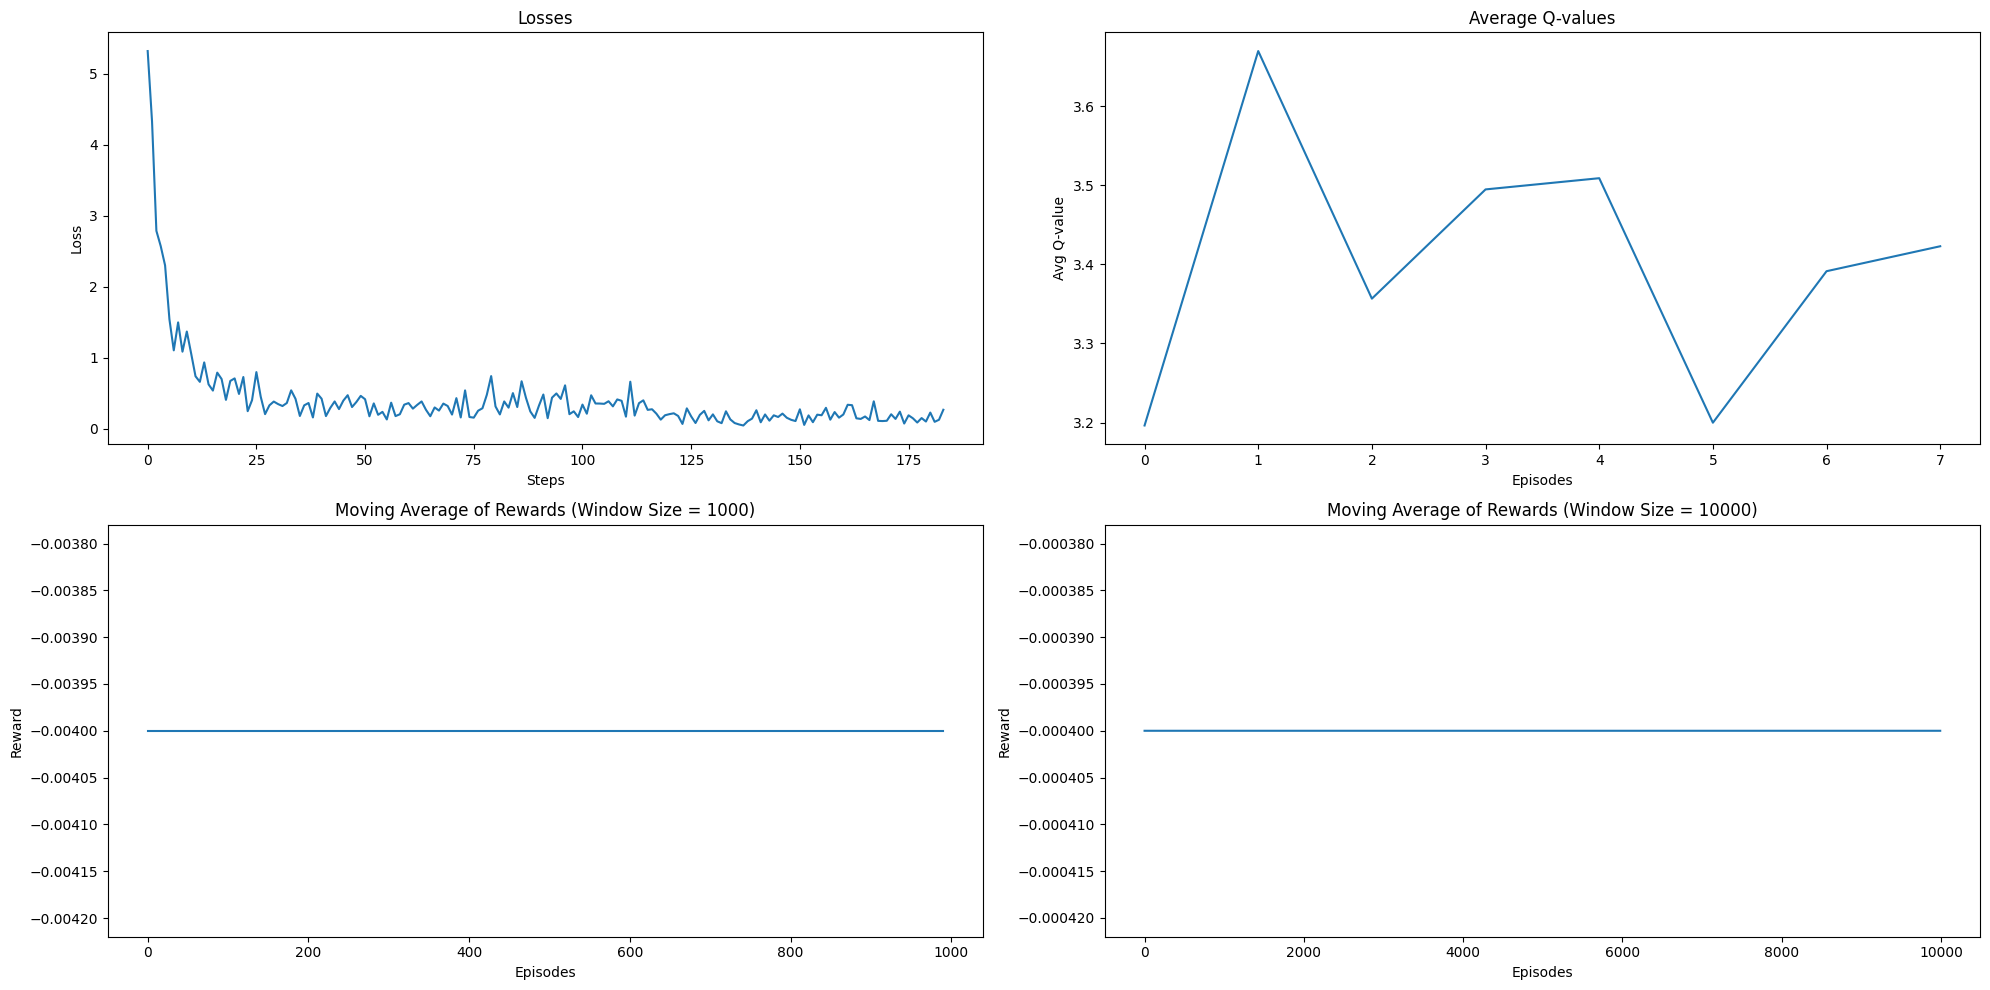

In [11]:
# Saving model and other metrics using checkpoints
PATH = "trained_model.pth"
TOTAL_NUM_EPISODES = num_episodes + total_num_episodes

replay_buffer.save_buffer()
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'losses': losses,
    'total_num_episodes': TOTAL_NUM_EPISODES,
    'avg_q_values': avg_q_values,
    'episode_rewards': episode_rewards_list
}, PATH)

print("Total number of episodes on which model is trained: ", TOTAL_NUM_EPISODES)

def calculate_moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

window_size_1000 = 1000
window_size_10000 = 10000
moving_avg_rewards_1000 = calculate_moving_average(episode_rewards_list, window_size_1000)
moving_avg_rewards_10000 = calculate_moving_average(episode_rewards_list, window_size_10000)


plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(losses)
plt.title('Losses')
plt.xlabel('Steps')
plt.ylabel('Loss')

plt.subplot(2, 2, 2)
plt.plot(avg_q_values)
plt.title('Average Q-values')
plt.xlabel('Episodes')
plt.ylabel('Avg Q-value')

plt.subplot(2, 2, 3)
plt.plot(moving_avg_rewards_1000)
plt.title('Moving Average of Rewards (Window Size = 1000)')
plt.xlabel('Episodes')
plt.ylabel('Reward')

plt.subplot(2, 2, 4)
plt.plot(moving_avg_rewards_10000)
plt.title('Moving Average of Rewards (Window Size = 10000)')
plt.xlabel('Episodes')
plt.ylabel('Reward')

plt.tight_layout()
plt.show()